In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

2022-09-06 19:18:42.685661: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-09-06 19:18:42.685693: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.ae_mlp import AE_MLP
from src.models.som import SOM

In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

### Загрузка из оригинальных excel файлов

Тут надо покрасивее, но пока нет времени

In [6]:
# data_test = pd.read_excel('./SWAT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Attack_v0.xlsx', 
#                           skiprows=1, 
#                           parse_dates=True,
#                           index_col=[0])
# data_test = data_test.rename(columns={'Normal/Attack':'anomaly'})

In [7]:
# data_test['anomaly'].value_counts()

In [8]:
# data_test['anomaly'] = data_test['anomaly'].apply(lambda x: 0 if x=='Normal' else 1)

# # исправление некорректного времени надо как то красивее, но нет пока времени на красоту
# data_test.reset_index(inplace=True)
# replace_idx = data_test[data_test[' Timestamp'] >= pd.to_datetime('2016-02-01')].index
# data_test.loc[replace_idx,' Timestamp'] = data_test.loc[replace_idx,' Timestamp'].apply(pd.Timestamp.replace, month=1, day=2) 
# data_test.index = data_test.pop(' Timestamp')

# data_test.tail()

In [9]:
# data_test['anomaly'].value_counts()

In [10]:
# data_train = pd.read_excel('./SWAT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Normal_v1.xlsx', 
#                           skiprows=1, 
#                           parse_dates=True,
#                           index_col=[0])

# data_train.drop('Normal/Attack', axis=1, inplace=True)
# data_train

In [11]:
# df_train, df_test = prepare_data(data_train, data_test)

### Загрузка из подготовленных CSV

In [12]:
df_train = pd.read_csv('./data/SWAT15_df_train.csv', index_col=[0], parse_dates=True)
df_train.head(3)

FIT101    LIT101  MV101  P101  P102    AIT201    AIT202  \
 Timestamp                                                                     
2015-12-22 16:30:00     0.0  124.3135      1     1     1  251.9226  8.313446   
2015-12-22 16:30:01     0.0  124.3920      1     1     1  251.9226  8.313446   
2015-12-22 16:30:02     0.0  124.4705      1     1     1  251.9226  8.313446   

                       AIT203  FIT201  MV201  ...    FIT501    FIT502  \
 Timestamp                                    ...                       
2015-12-22 16:30:00  312.7916     0.0      1  ...  0.001538  0.001409   
2015-12-22 16:30:01  312.7916     0.0      1  ...  0.001538  0.001409   
2015-12-22 16:30:02  312.7916     0.0      1  ...  0.001538  0.001409   

                       FIT503  FIT504  P501    PIT501  PIT502  PIT503  \
 Timestamp                                                              
2015-12-22 16:30:00  0.001664     0.0     1  9.100231     0.0  3.3485   
2015-12-22 16:30:01  0.001664     0.0     1  9.100231     0.0  3.3485   
2015-12-22 16:30:02  0.001664     0.0     1  9.100231     0.0  3.3485   

                       FIT601  P602  
 Timestamp                           
2015-12-22 16:30:00  0.000256     1  
2015-12-22 16:30:01  0.000256     1  
2015-12-22 16:30:02  0.000256     1  

[3 rows x 46 columns]

In [13]:
df_test = pd.read_csv('./data/SWAT15_df_test.csv', index_col=[0], parse_dates=True)
df_test.head(3)

FIT101    LIT101   MV101  P101  P102    AIT201  \
 Timestamp                                                              
2015-12-28 10:00:00  2.427057  522.8467       2     2     1  262.0161   
2015-12-28 10:00:01  2.446274  522.8860       2     2     1  262.0161   
2015-12-28 10:00:02  2.489191  522.8467       2     2     1  262.0161   

                       AIT202    AIT203    FIT201   MV201  ...    FIT502  \
 Timestamp                                                 ...             
2015-12-28 10:00:00  8.396437  328.6337  2.445391       2  ...  1.279621   
2015-12-28 10:00:01  8.396437  328.6337  2.445391       2  ...  1.297554   
2015-12-28 10:00:02  8.394514  328.6337  2.442316       2  ...  1.293967   

                       FIT503    FIT504  P501    PIT501    PIT502    PIT503  \
 Timestamp                                                                    
2015-12-28 10:00:00  0.735269  0.307786     2  250.8652  1.649953  189.5988   
2015-12-28 10:00:01  0.735269  0.307786     2  250.8652  1.649953  189.6789   
2015-12-28 10:00:02  0.735269  0.308619     2  250.8812  1.649953  189.6789   

                       FIT601  P602  anomaly  
 Timestamp                                    
2015-12-28 10:00:00  0.000128     1        0  
2015-12-28 10:00:01  0.000128     1        0  
2015-12-28 10:00:02  0.000128     1        0  

[3 rows x 47 columns]

In [14]:
summary = {}

## Подготовка train/test

In [15]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)


## OC SVM

In [16]:
description='SWAT_Dec15_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

2022-09-06 19:18:50.957373: find saved model: ./saved_models/SWAT_Dec15_svm_default, loading...


In [17]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

SWAT_Dec15_svm_default
f1_score: 0.28
accuracy_score: 0.47
precision_score: 0.17
recall_score: 0.86


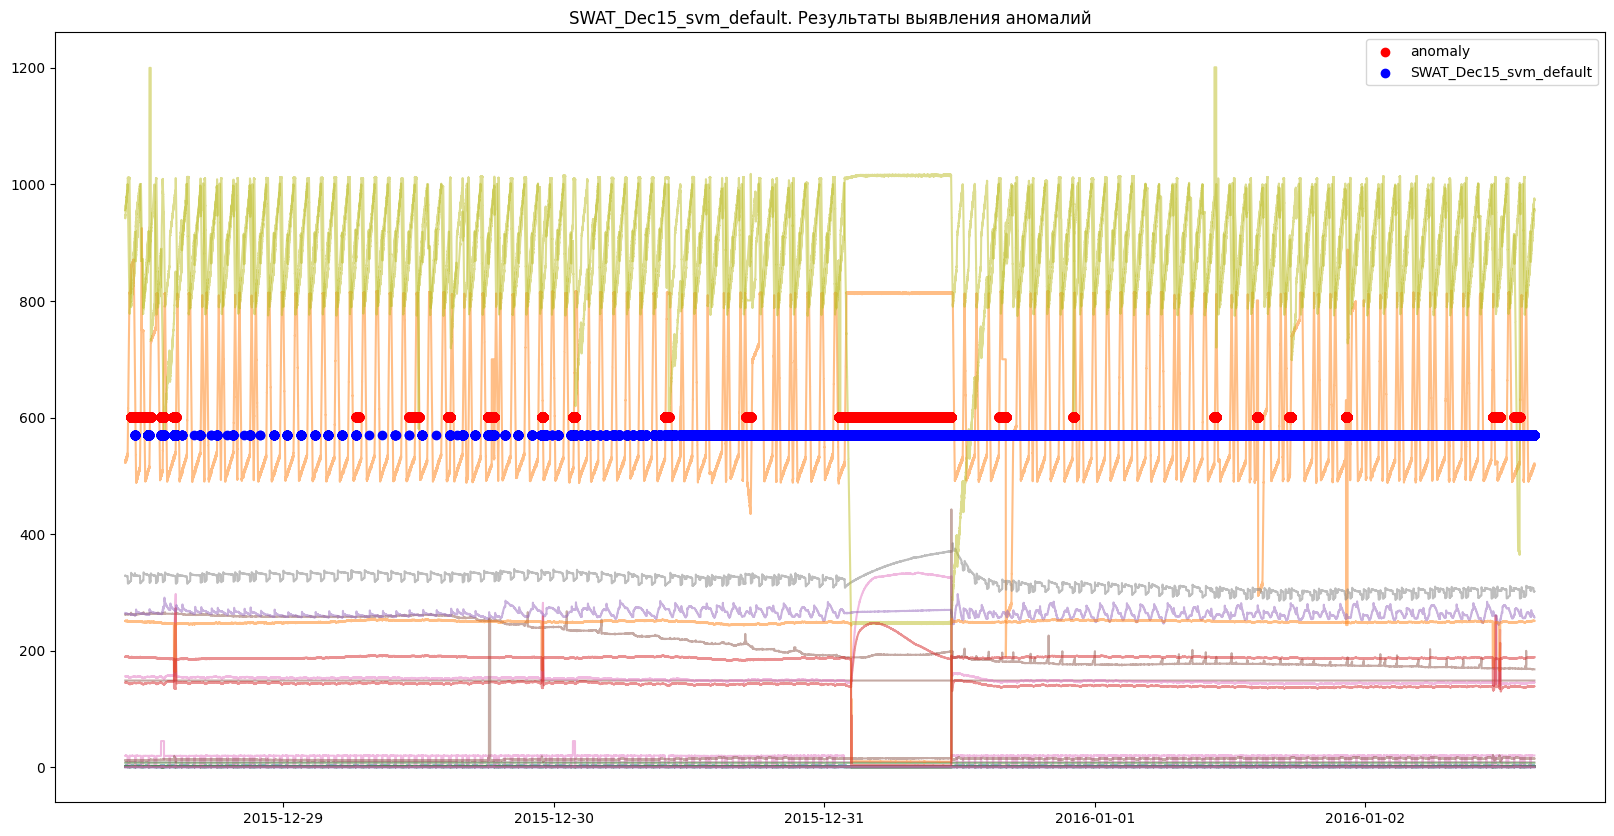

In [18]:
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-06 19:20:22.057582: find saved model: ./saved_models/SWAT_Dec15_svm_minmax, loading...
SWAT_Dec15_svm_minmax
f1_score: 0.26
accuracy_score: 0.37
precision_score: 0.15
recall_score: 0.89


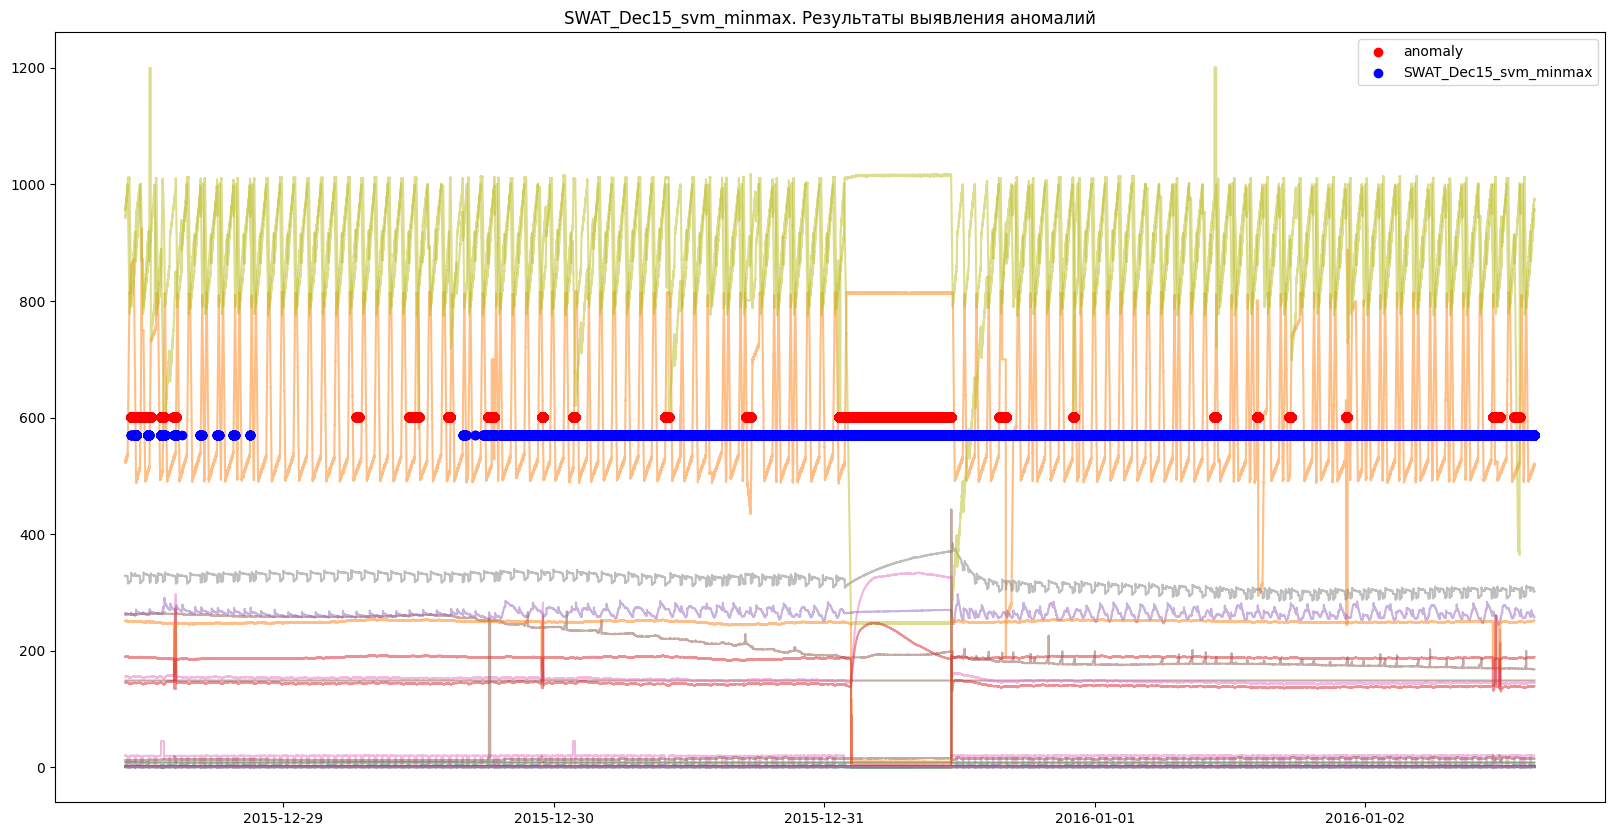

In [19]:
description='SWAT_Dec15_svm_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [20]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [21]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)


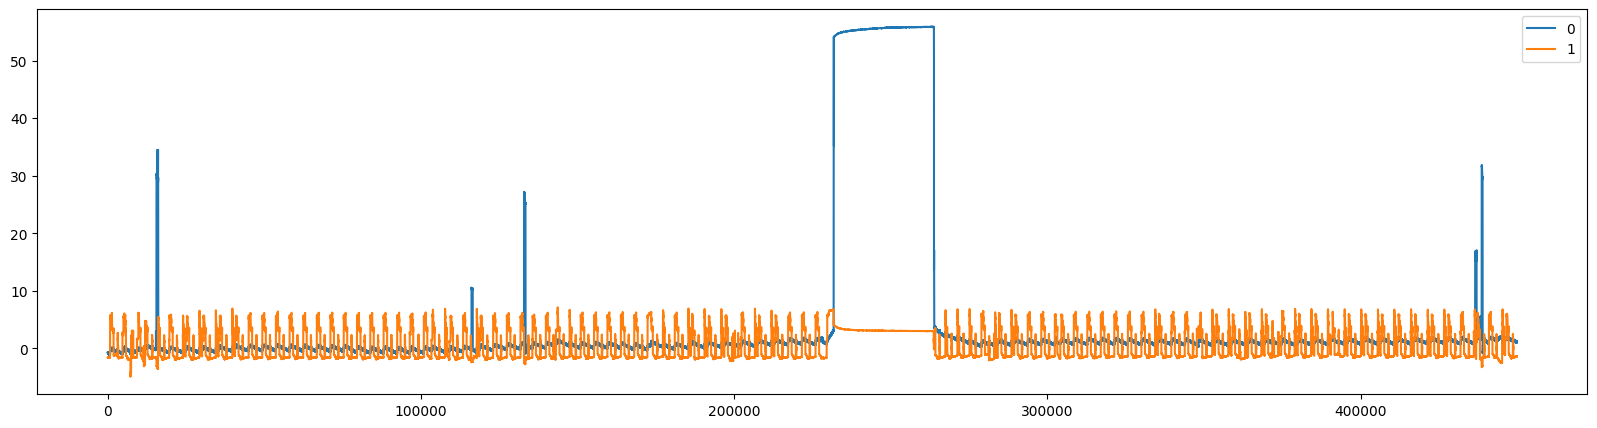

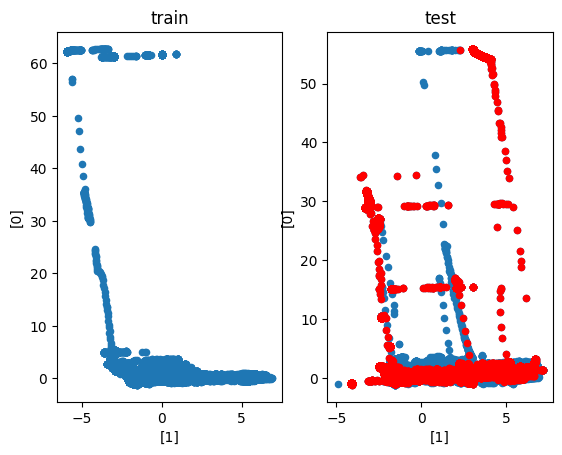

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

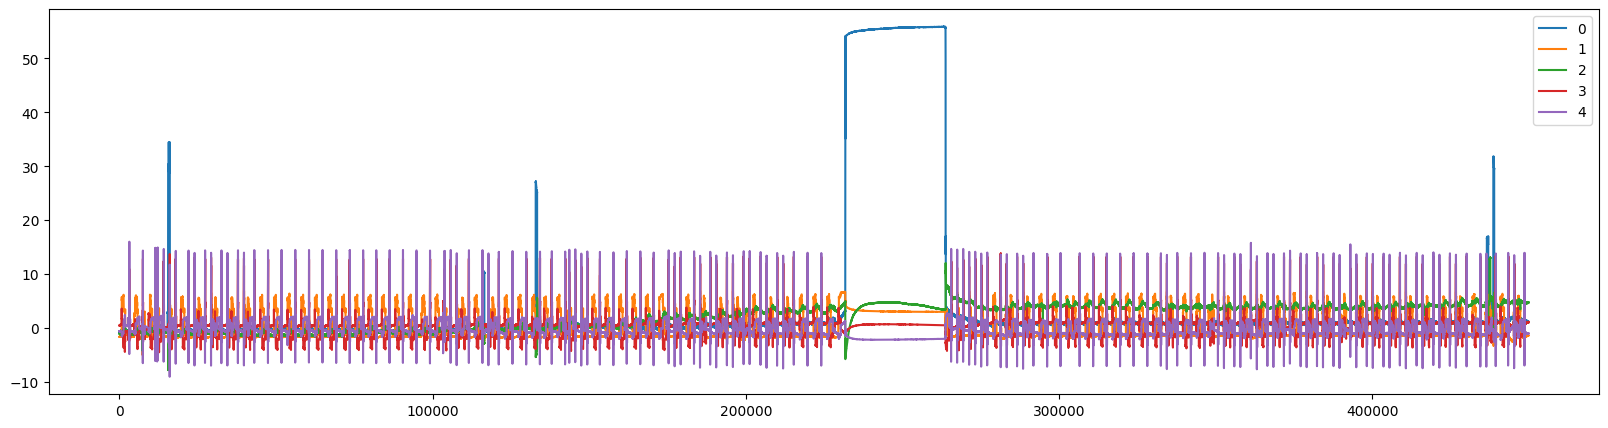

In [23]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [24]:
model = LOF()

2022-09-06 19:21:56.177642: find saved model: ./saved_models/SWAT_Dec15_lof_n5, loading...
Train prediction score statistics
            min: -165.84487051770736
            mean: -1.054604631220998
            max: -0.8895952013906652


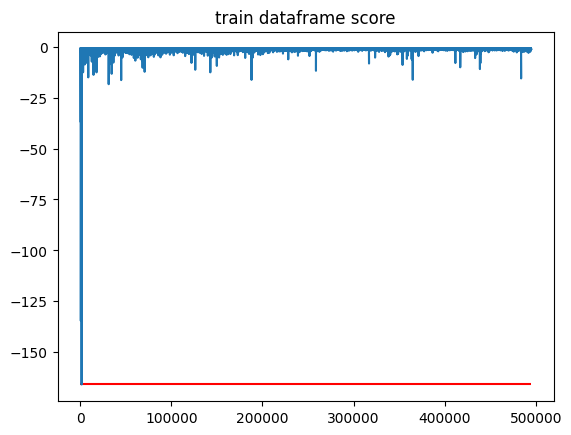

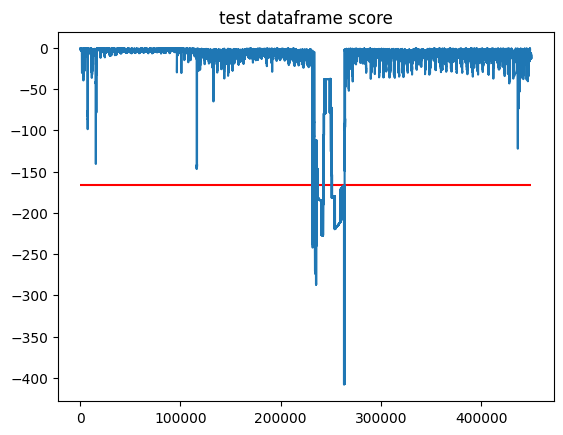

SWAT_Dec15_lof_n5
f1_score: 0.56
accuracy_score: 0.93
precision_score: 1.00
recall_score: 0.39


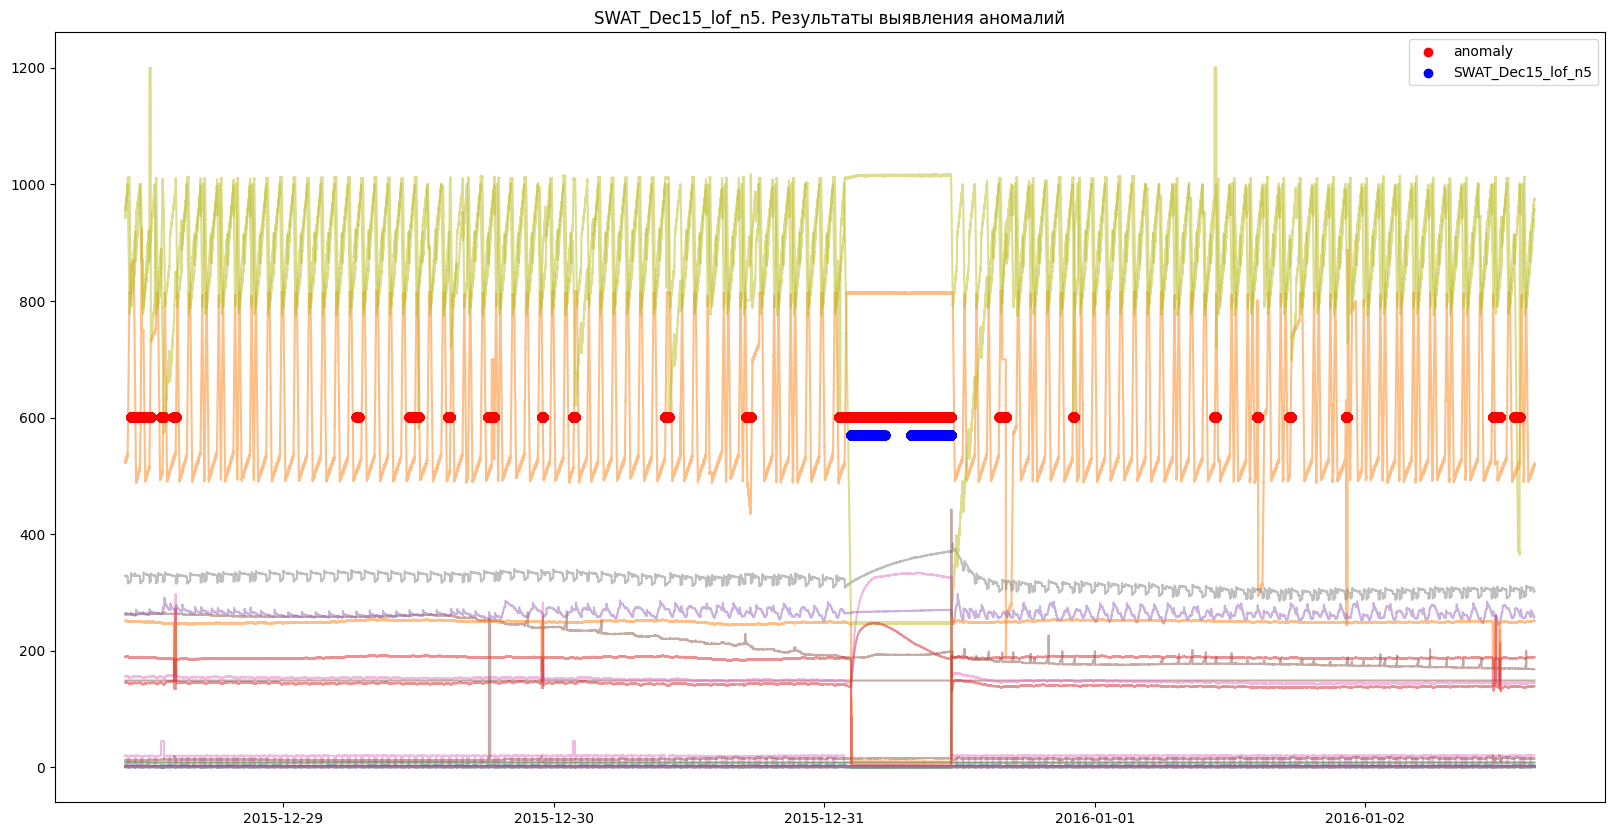

In [25]:
description = f'SWAT_Dec15_lof_n{N_COMPONENTS}'

predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

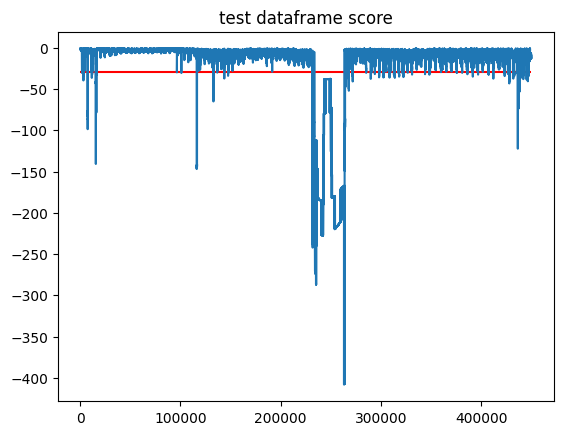

SWAT_Dec15_lof_n5
f1_score: 0.73
accuracy_score: 0.94
precision_score: 0.91
recall_score: 0.60


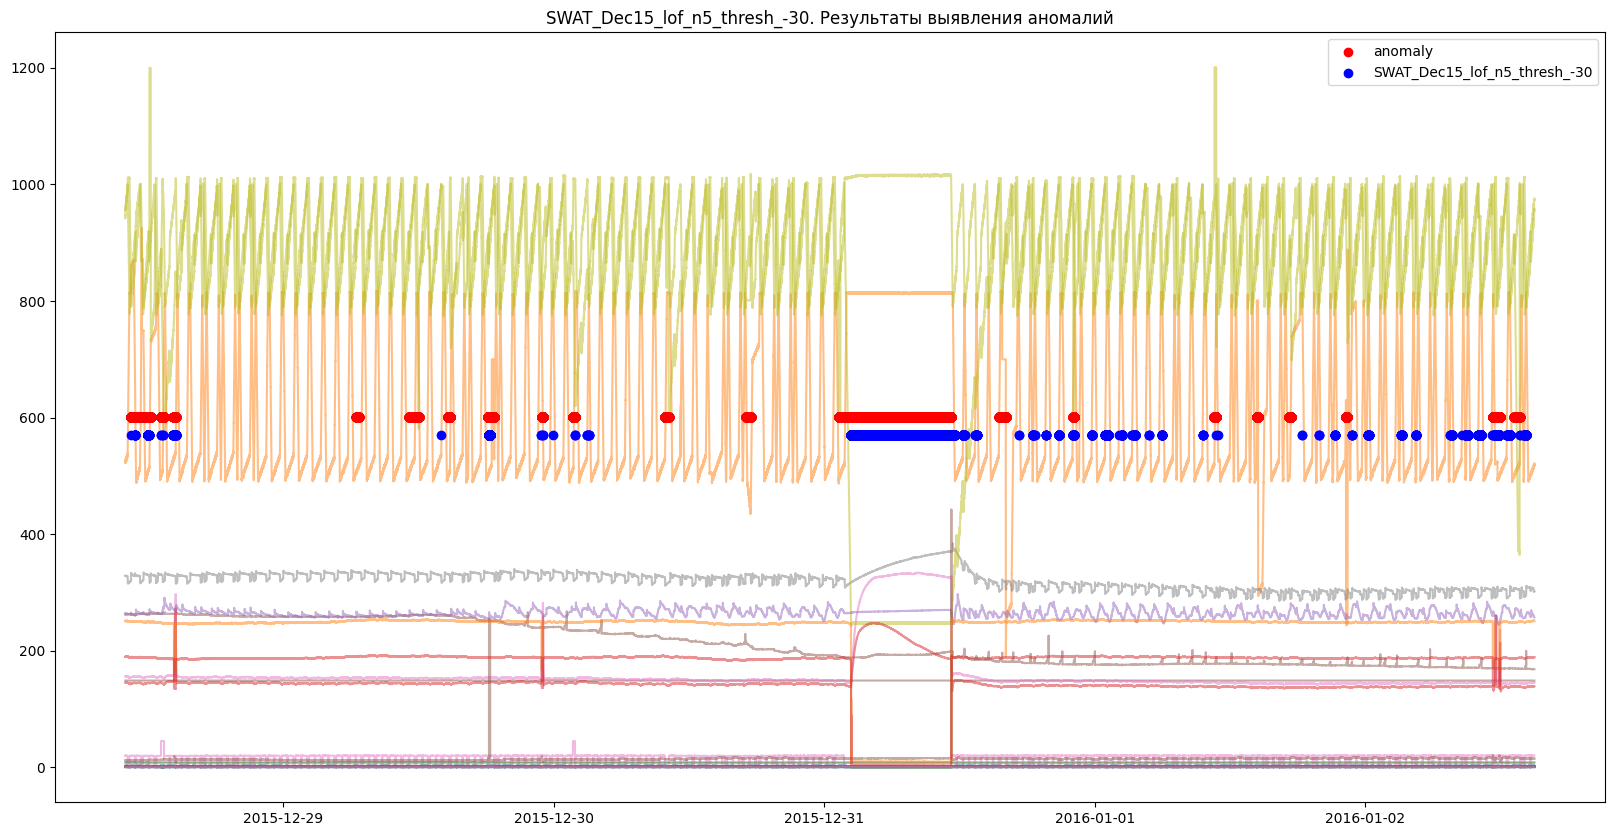

In [26]:
threshold = -30
description = f'SWAT_Dec15_lof_n{N_COMPONENTS}_thresh_{threshold}'

y_pred = predictor.get_anomalies(threshold = threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-06 19:22:49.338768: find saved model: ./saved_models/SWAT_Dec15_iF_default, loading...
SWAT_Dec15_iF_default
f1_score: 0.72
accuracy_score: 0.95
precision_score: 1.00
recall_score: 0.57


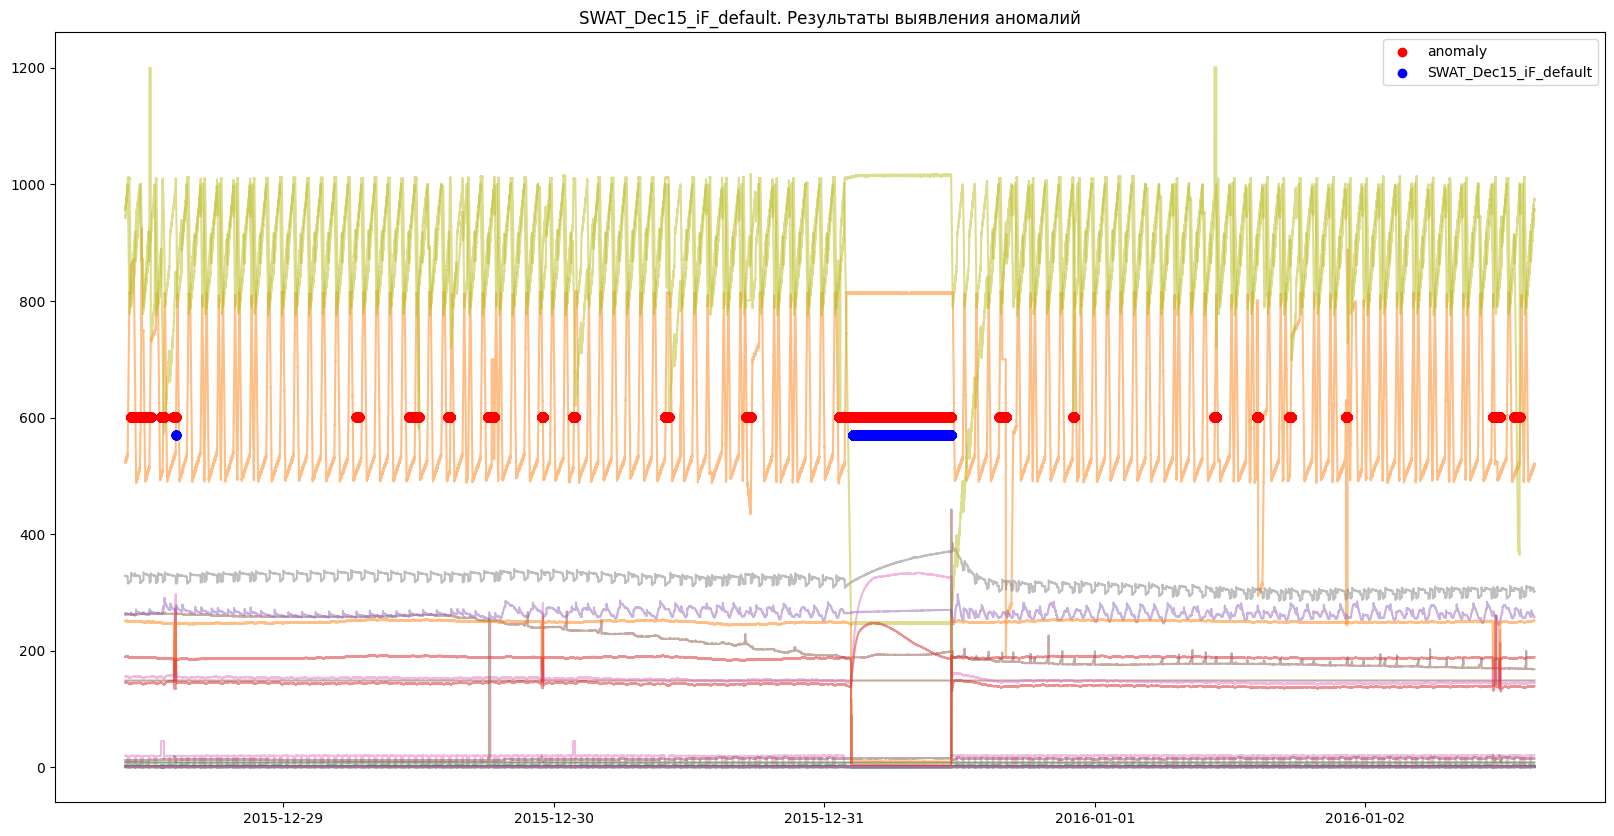

In [27]:
description = f'SWAT_Dec15_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-06 19:23:09.955594: find saved model: ./saved_models/SWAT_Dec15_iF_n_200_c_0005, loading...
SWAT_Dec15_iF_n_200_c_0005
f1_score: 0.74
accuracy_score: 0.95
precision_score: 0.98
recall_score: 0.59


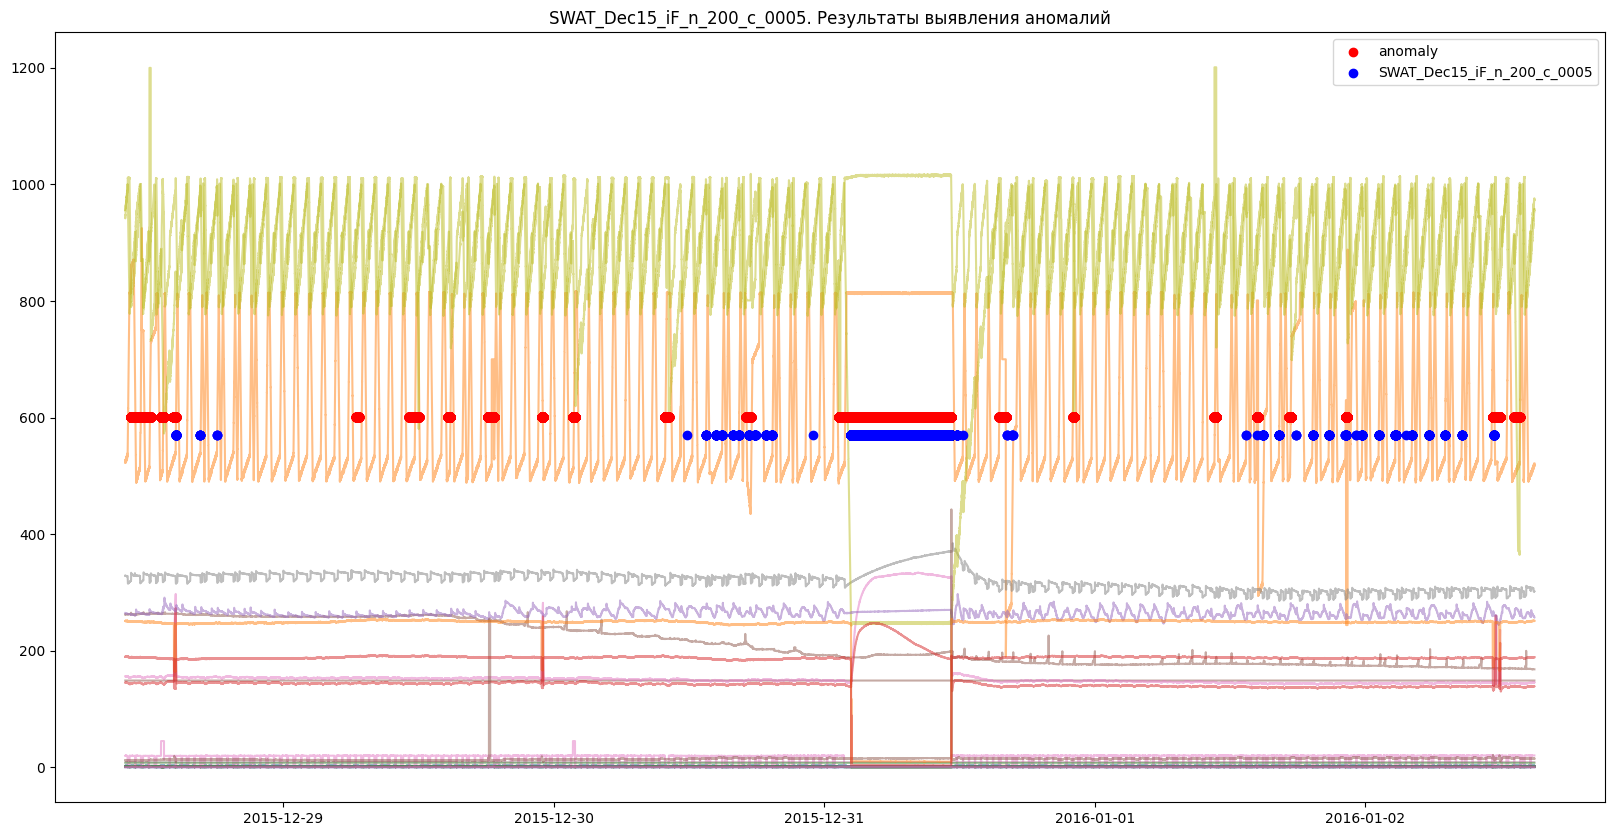

In [28]:
n_estimators, contamination = 200, 0.005

description = f"SWAT_Dec15_iF_n_{n_estimators}_c_{str(contamination).replace('.','')}"

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=n_estimators, contamination=contamination)

predictor = Predictor(model, [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder LSTM

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Resampling... (1T)
(8250, 46), (7500, 46), (7500,),
Create sequences with window size 30...
Размеры выборок:
            x_train: (494971, 30, 46)
            x_test: (449890, 30, 46)
            y_test: (449890, 30)
2022-09-06 19:23:55.923659: find saved model: ./saved_models/SWAT_Dec15_ae_lstm_window_30_resample_1T, loading...


2022-09-06 19:23:55.886198: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-09-06 19:23:55.893206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 19:23:55.893777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.8GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-09-06 19:23:55.893849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 19:23:55.894387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:

Train prediction score statistics
            min: 11.539351651886347
            mean: 21.63147330258595
            max: 5977.312132822594


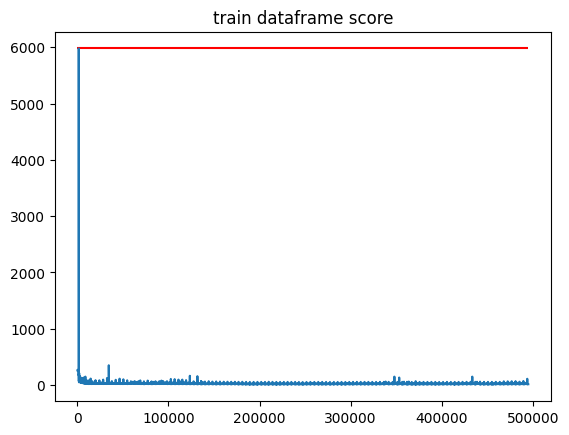

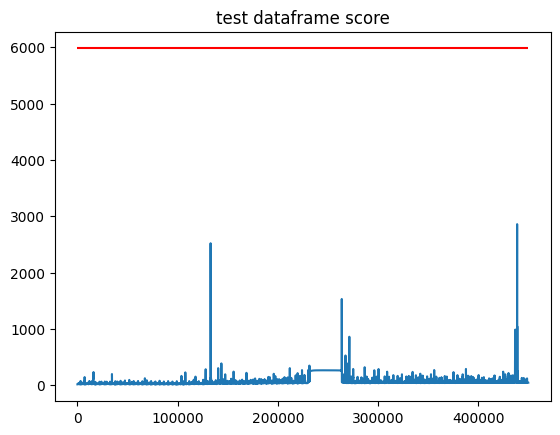

(449890,)
SWAT_Dec15_ae_lstm_window_30_resample_1T
f1_score: 0.00
accuracy_score: 0.88
precision_score: 0.00
recall_score: 0.00


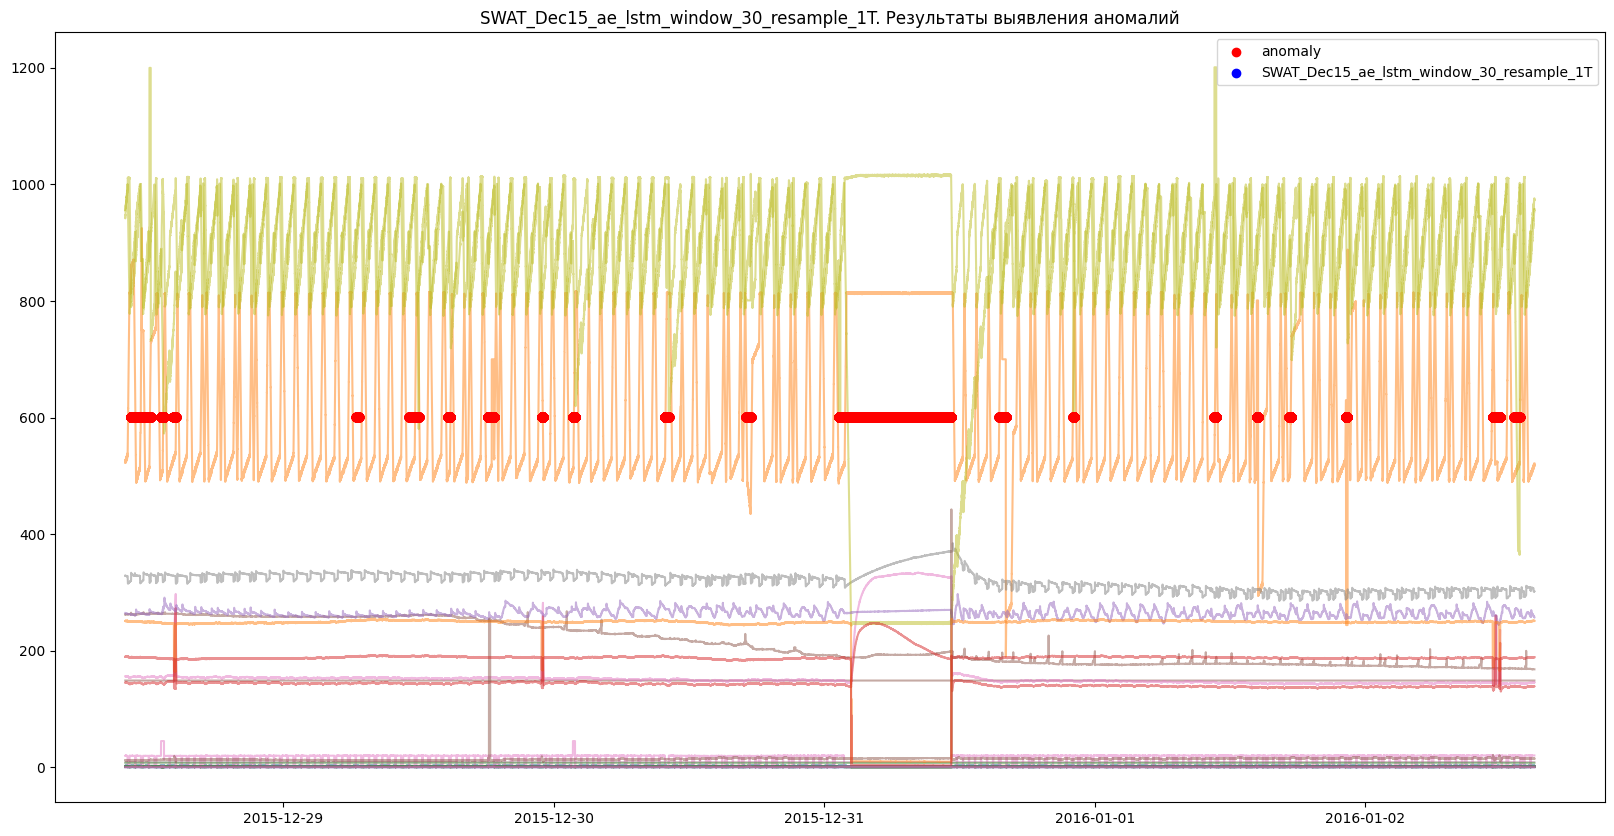

In [29]:
window_size = 30
resample_rate = '1T'

description = f'SWAT_Dec15_ae_lstm_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

2022-09-06 19:30:35.280860: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 2483392800 exceeds 10% of free system memory.


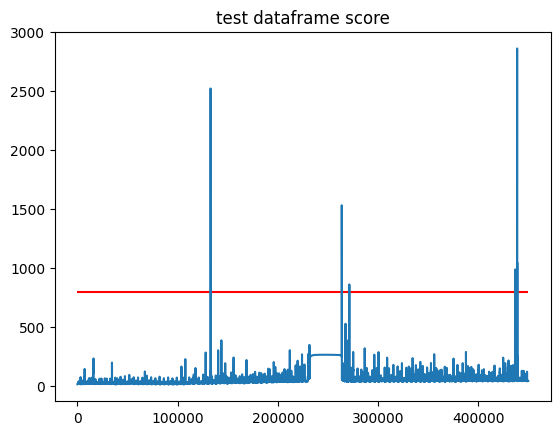

(449890,)
SWAT_Dec15_ae_lstm_window_30_resample_1T
f1_score: 0.00
accuracy_score: 0.88
precision_score: 0.60
recall_score: 0.00


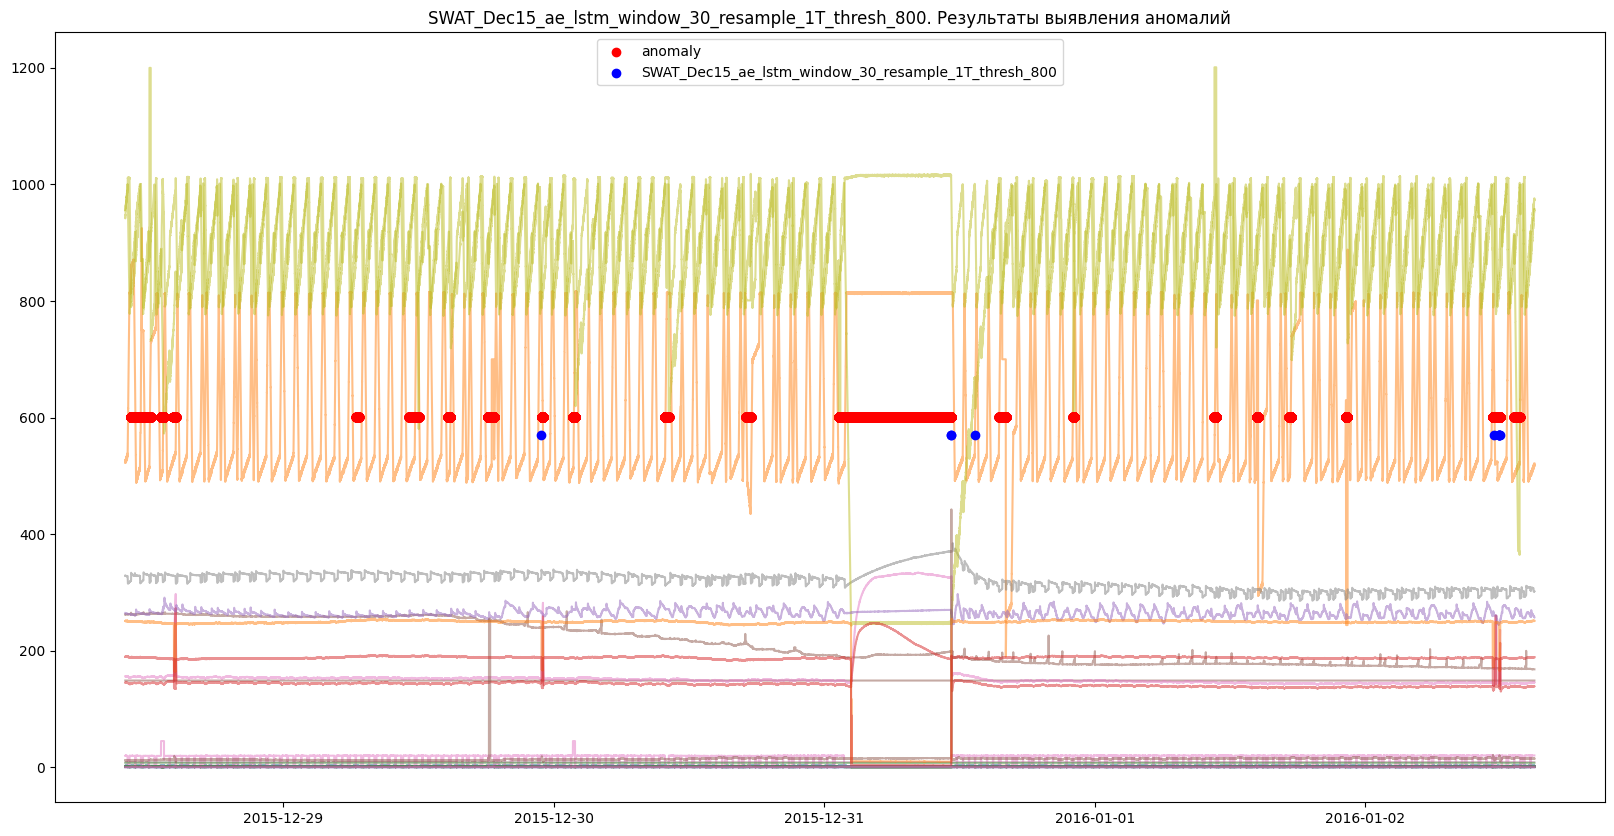

In [30]:
threshold = 800

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f'{description}_thresh_{threshold}')

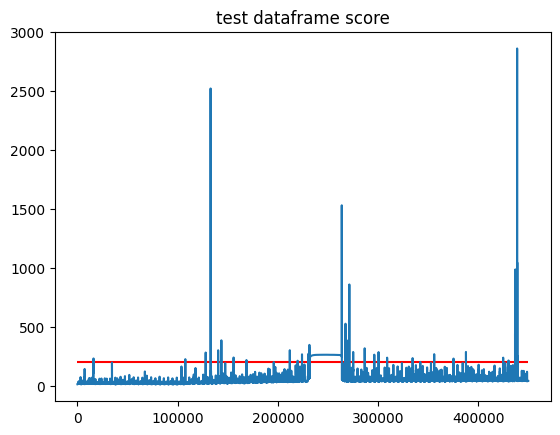

(449890,)
SWAT_Dec15_ae_lstm_window_30_resample_1T
f1_score: 0.74
accuracy_score: 0.95
precision_score: 1.00
recall_score: 0.59


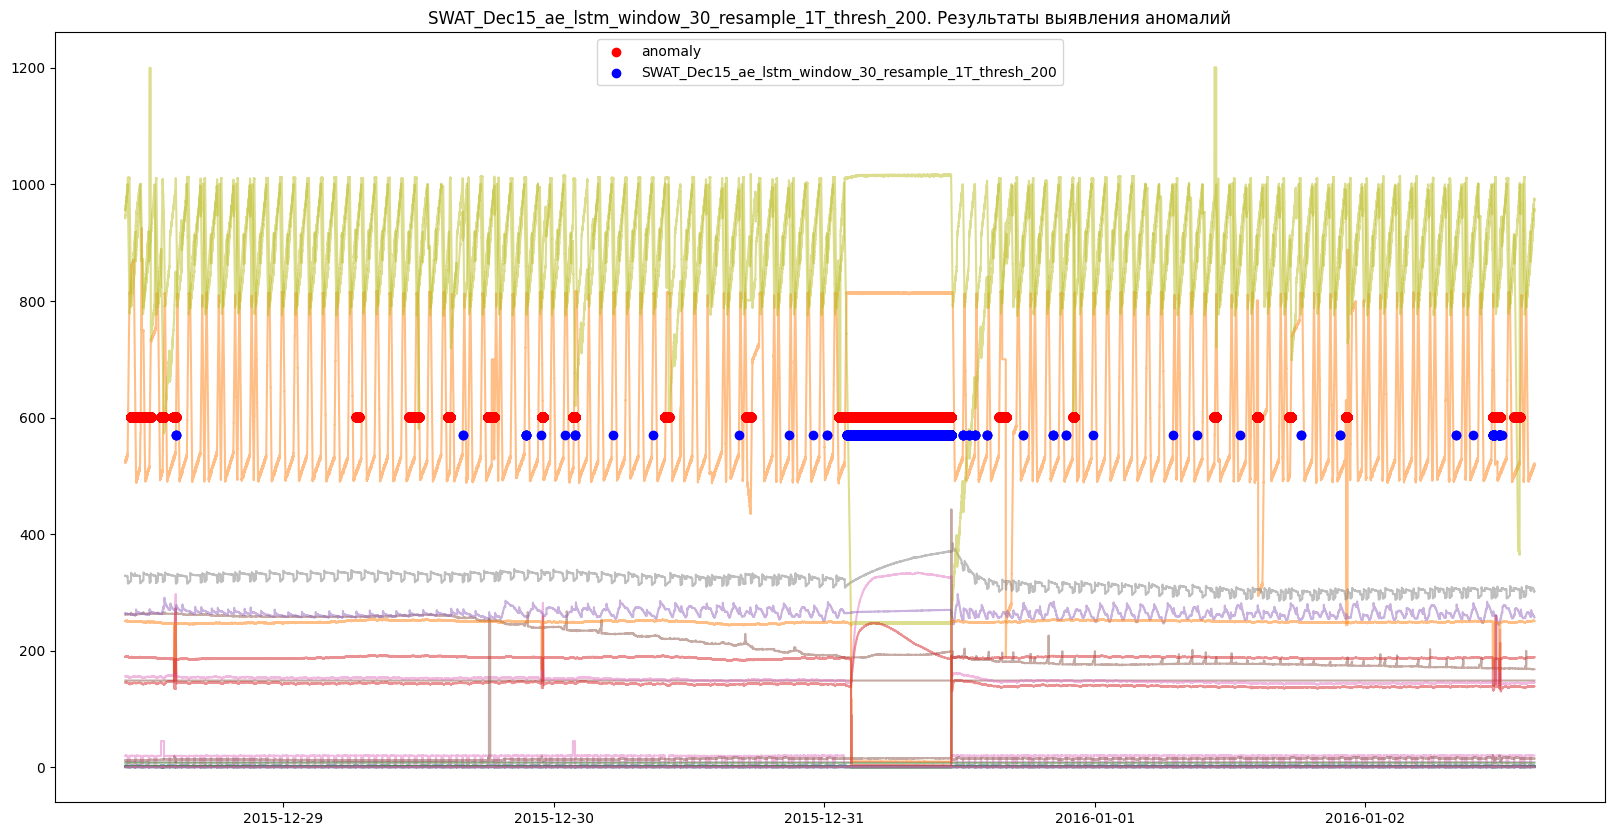

In [31]:
threshold = 200

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f'{description}_thresh_{threshold}')

## SOM

In [32]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)


2022-09-06 19:38:29.744044: find saved model: ./saved_models/SWAT_Dec15_som_default, loading...


IntProgress(value=0, description='Computing', max=449919, style=ProgressStyle(bar_color='#61dc8a'))

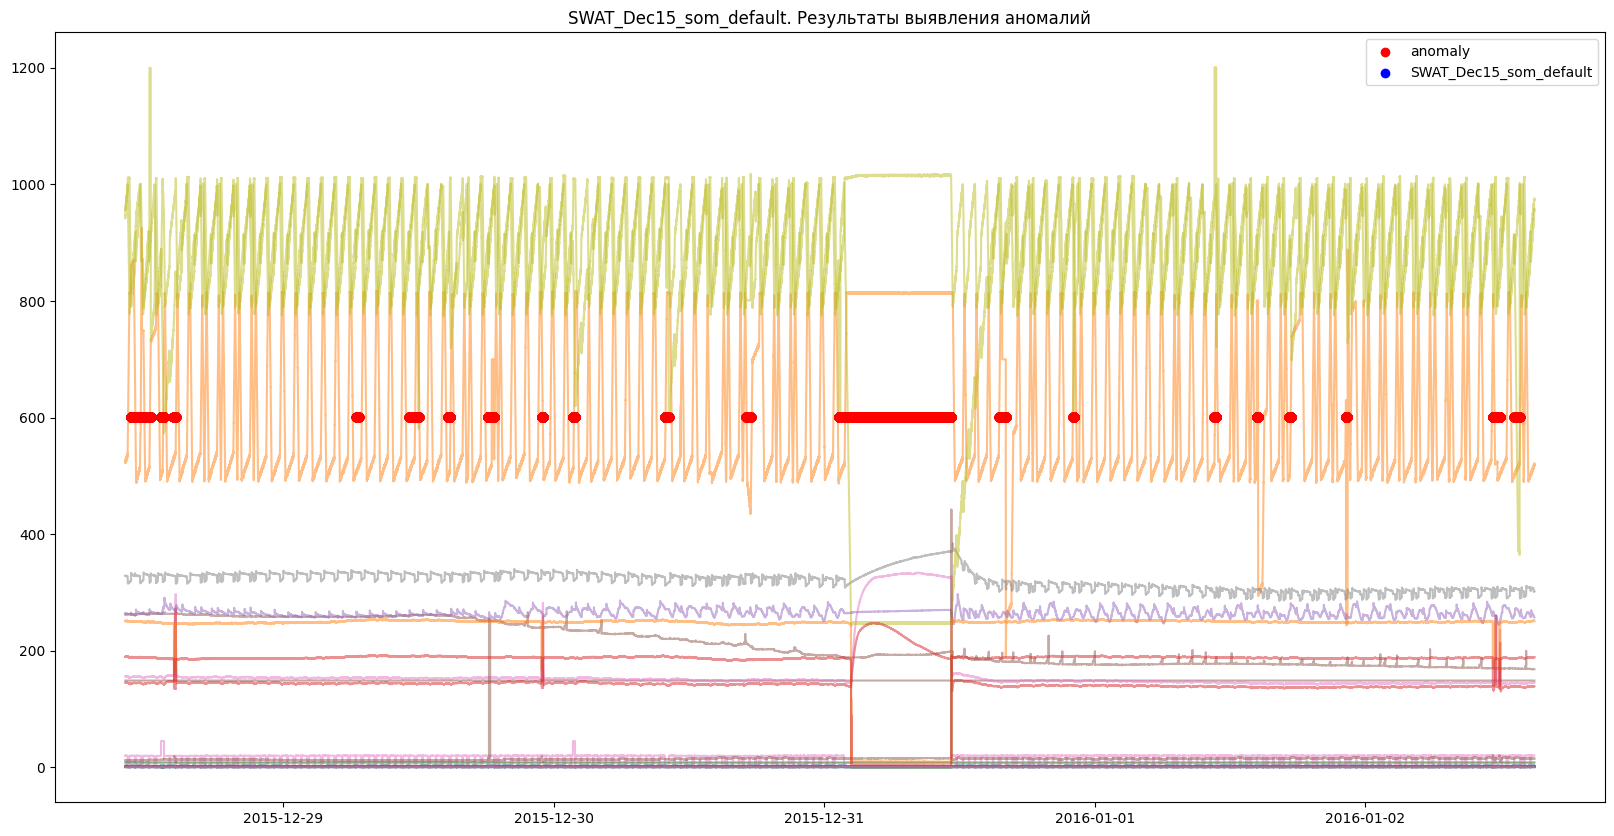

In [33]:
description = f'SWAT_Dec15_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

IntProgress(value=0, description='Computing', max=449919, style=ProgressStyle(bar_color='#61dc8a'))

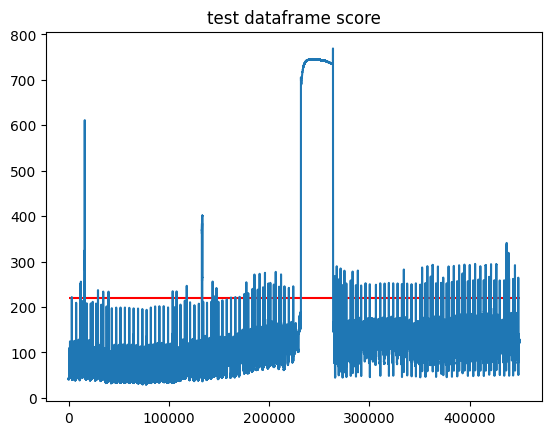

(449919,)
SWAT_Dec15_som_default
f1_score: 0.74
accuracy_score: 0.95
precision_score: 0.91
recall_score: 0.62


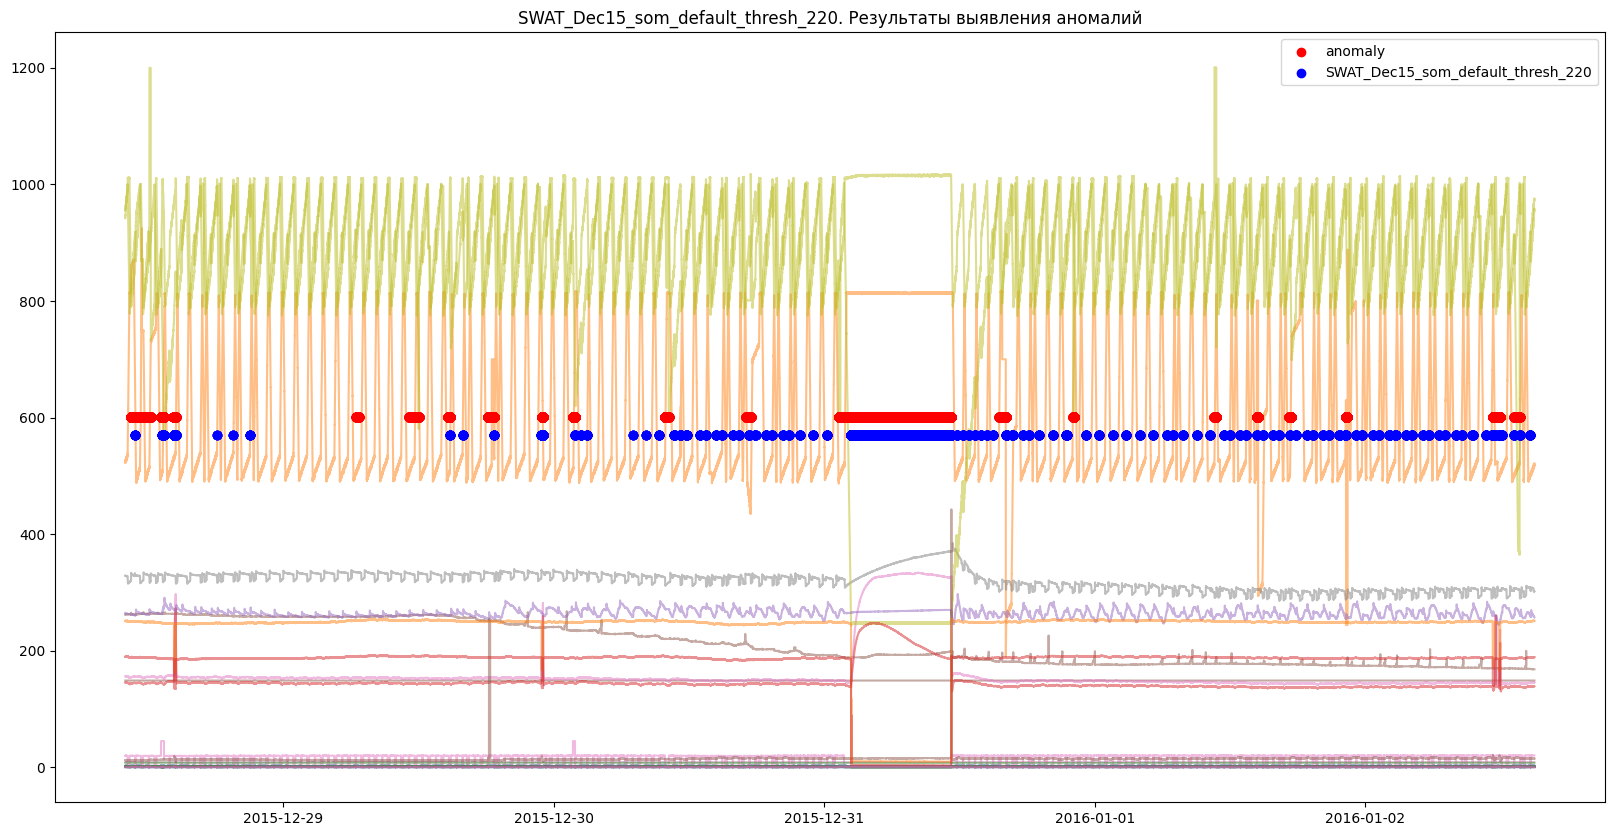

In [34]:
threshold = 220

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'{description}_thresh_{threshold}')

## Autoencoder MLP

In [35]:
description = f'SWAT_Dec15_ae_mlp_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = AE_MLP()

predictor = Predictor(model, [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-06 19:56:35.431738: find saved model: ./saved_models/SWAT_Dec15_ae_mlp_default, loading...


Train prediction score statistics
            min: 0.12020688012700409
            mean: 0.32753295311267705
            max: 5.602988662656428


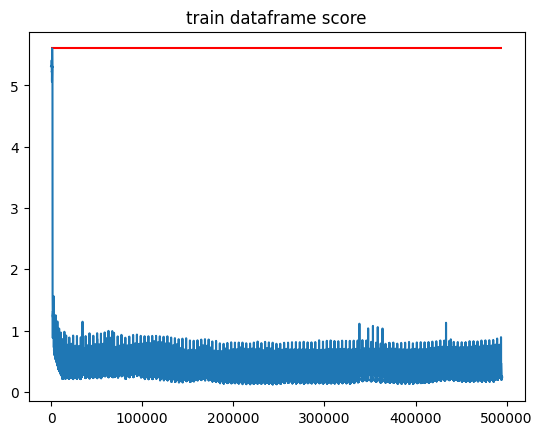

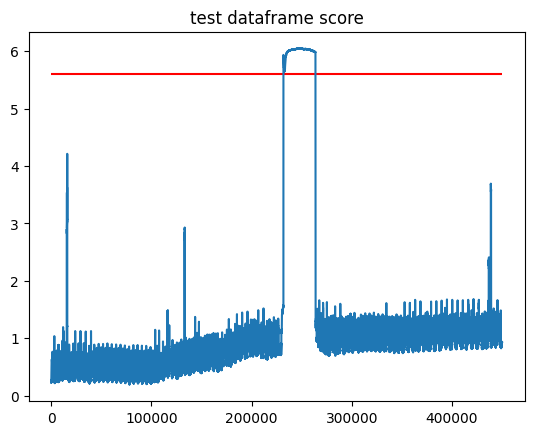

SWAT_Dec15_ae_mlp_default
f1_score: 0.74
accuracy_score: 0.95
precision_score: 1.00
recall_score: 0.58


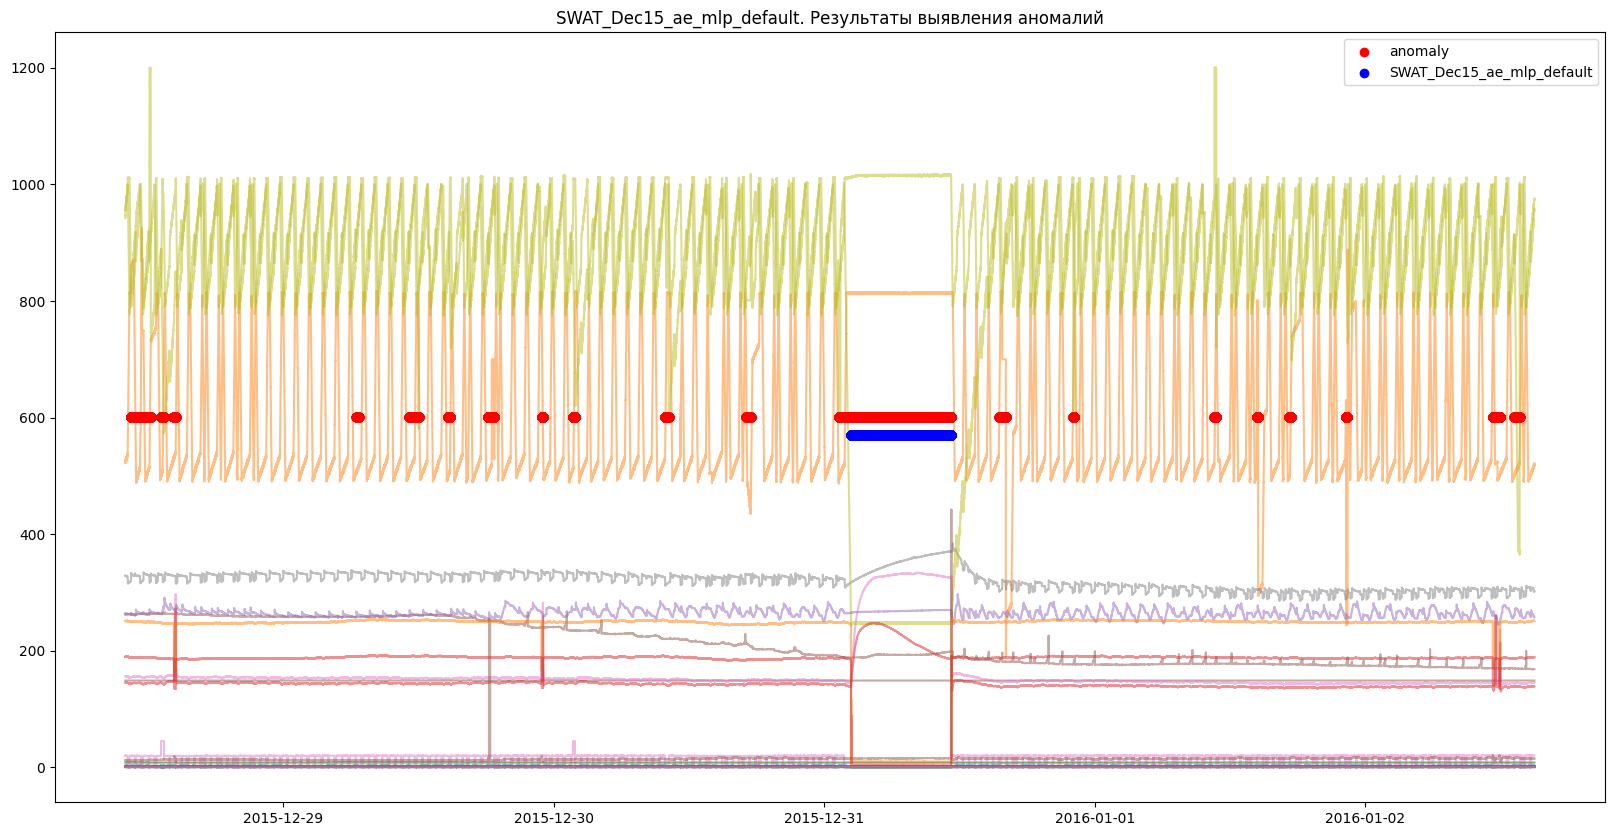

In [36]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

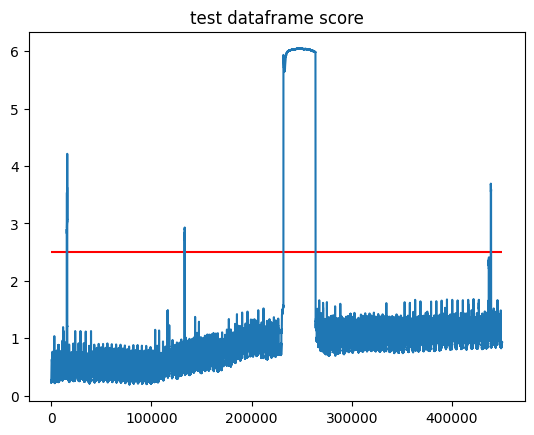

SWAT_Dec15_ae_mlp_default
f1_score: 0.76
accuracy_score: 0.95
precision_score: 1.00
recall_score: 0.61


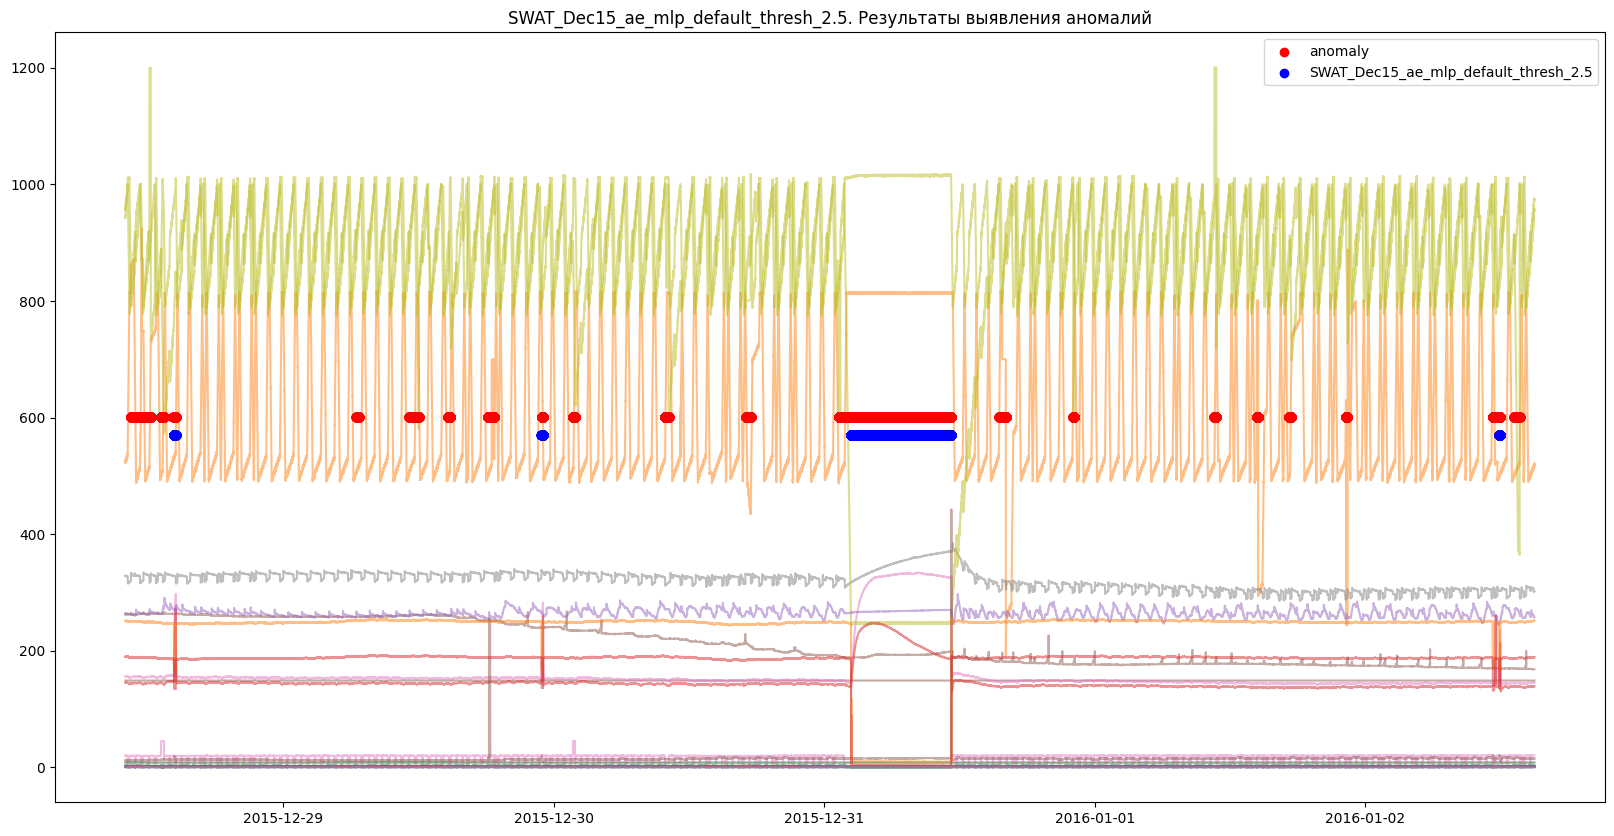

In [37]:
threshold = 2.5

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'{description}_thresh_{threshold}')

# Сводная таблица

In [38]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.format("{0:,.2f}").background_gradient(cmap='Blues')

In [39]:
x_pred = model.predict(x_train)